# Statistics in HEP End Sem
Name: Vedant Bhutra

In [61]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
from iminuit import Minuit

In [3]:
# read csv file and store data in a numpy array
toy_data = []

with open('toy_histograms.csv', 'r') as file:
    reader = csv.reader(file)
    flag = True
    for row in reader:
        if flag == True:
            flag = False
            continue  # skip header
        toy_data.append([float(i) for i in row])

toy_data = np.array(toy_data)

We separate the data into a list of datasets

In [4]:
#testing masking in Python
mask = (toy_data[:,0] == 0)
toy_data[mask]

array([[0.00000000e+00, 1.00000000e+00, 5.00000000e-02, 9.45000000e+02,
        3.07408523e+01],
       [0.00000000e+00, 2.00000000e+00, 1.50000000e-01, 9.27000000e+02,
        3.04466747e+01],
       [0.00000000e+00, 3.00000000e+00, 2.50000000e-01, 8.68000000e+02,
        2.94618397e+01],
       [0.00000000e+00, 4.00000000e+00, 3.50000000e-01, 8.45000000e+02,
        2.90688837e+01],
       [0.00000000e+00, 5.00000000e+00, 4.50000000e-01, 8.40000000e+02,
        2.89827535e+01],
       [0.00000000e+00, 6.00000000e+00, 5.50000000e-01, 7.97000000e+02,
        2.82311884e+01],
       [0.00000000e+00, 7.00000000e+00, 6.50000000e-01, 7.68000000e+02,
        2.77128129e+01],
       [0.00000000e+00, 8.00000000e+00, 7.50000000e-01, 7.23000000e+02,
        2.68886593e+01],
       [0.00000000e+00, 9.00000000e+00, 8.50000000e-01, 7.60000000e+02,
        2.75680975e+01],
       [0.00000000e+00, 1.00000000e+01, 9.50000000e-01, 6.82000000e+02,
        2.61151297e+01],
       [0.00000000e+00, 1.1000

In [5]:
# from direct observation
n_bins = 100
n_experiments = 712

Given a pseudo-dataset, we fit mu and sigma

In [ ]:
def exponential(x, a, lam):
    return a * np.exp(-lam * x)

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [54]:
#define likelihood function for exponential fit
def log_likelihood(Mu, a, lam, A, mu, sigma, data, centers):
    expected = exponential(centers, a, lam) + Mu * gaussian(centers, A, mu, sigma)
    expected[expected <= 0] = 1e-2  # avoid log(0)
    return np.sum(-expected + data * np.log(expected))

/var/folders/nn/l0nshg3s2j35_96gb8vpm3s40000gn/T/ipykernel_33776/1735699057.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-lam * x)


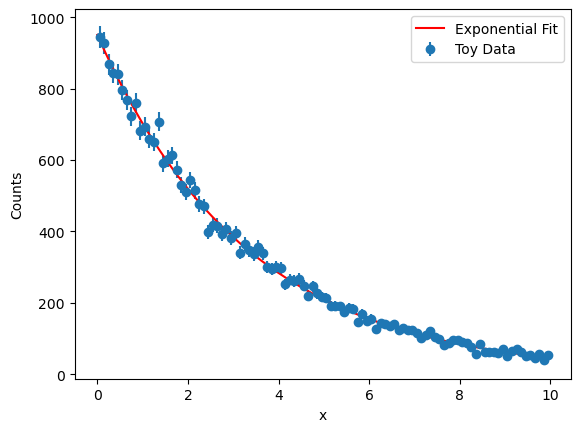

/var/folders/nn/l0nshg3s2j35_96gb8vpm3s40000gn/T/ipykernel_33776/1735699057.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-lam * x)


Reduced Chi-squared: 0.8892686479722589


In [53]:
test_statistics = []
L_nums = []
L_dens = []

for i in range(n_experiments):
    #for each toy dataset, fit an exponential and calculate the test statistic
    mask = (toy_data[:,0] == i)
    data = toy_data[mask]

    bin_centers = data[:,2]
    counts = data[:,3]
    errors = data[:,4]

    # Fit the background only histogram data to an exponential function
    popt, pcov = curve_fit(exponential, bin_centers, counts, sigma=errors, absolute_sigma=True)
    a_fit, lam_fit = popt

    # checking if the fit is good by chi-squared
    expected_counts = exponential(bin_centers, *popt)
    chi2 = np.sum(((counts - expected_counts) / errors) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    if i == 0:
        #plot the fit for the first toy dataset
        plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label='Toy Data')
        x_fit = np.linspace(0, max(bin_centers), 1000)
        y_fit = exponential(x_fit, *popt)
        plt.plot(x_fit, y_fit, label='Exponential Fit', color='red')
        plt.xlabel('x')
        plt.ylabel('Counts')
        plt.legend()
        plt.show()
        print(f"Reduced Chi-squared: {chi2_red}")

    # negative log-likelihood
    def neg_log_likelihood(Mu, a, lam, A, mu, sigma):
        return -log_likelihood(Mu, a, lam, A, mu, sigma, counts, bin_centers)
    
    # Minimize negative log-likelihood to find best-fit parameters including signal
    m = Minuit(neg_log_likelihood, Mu=0, a=a_fit, lam=lam_fit, A=1, mu=50, sigma=5)
    m.limits['Mu'] = (0, None)  # Mu must be non-negative
    m.migrad()
    Mu_fit, a_fit_d, lam_fit_d, A_fit, mu_fit, sigma_fit = m.values
    

    # test statistic = likelihood with background-only hypothesis / likelihood with fitted parameters
    test_statistic = (log_likelihood(Mu_fit, a_fit_d, lam_fit_d, A_fit, mu_fit, sigma_fit, counts, bin_centers) - 
                          log_likelihood(0, a_fit, lam_fit, 0, 0, 1, counts, bin_centers))

    test_statistics.append(test_statistic)

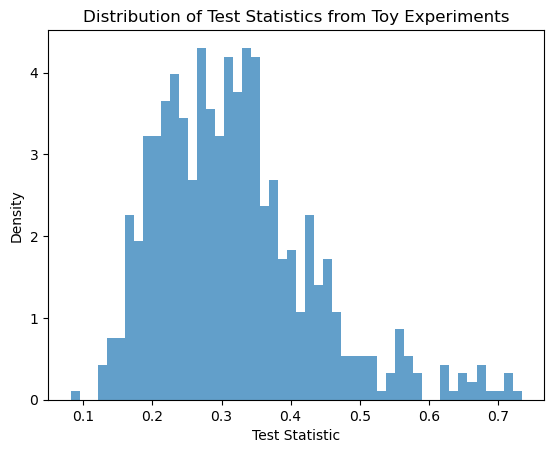

In [62]:
# plotting the distribution of test statistics  with background-only hypothesis
plt.hist(test_statistics, bins=50, density=True, alpha=0.7)
plt.xlabel('Test Statistic')
plt.ylabel('Density')
plt.title('Distribution of Test Statistics from Toy Experiments')
plt.show()

In [63]:
#read csv files and read each column into a list of floats
SplusB = []
with open('splusb_histogram_obs.csv', 'r') as file:
    csvreader = csv.reader(file)
    flag = True
    for row in csvreader:
        if flag == True:
            flag = False
            continue
        SplusB.append([float(i) for i in row])

SplusB = np.array(SplusB)

In [78]:
SplusB_bin_centers = [i[2] for i in SplusB]
SplusB_counts = [int(i[3]) for i in SplusB]
SplusB_errors = [i[4] for i in SplusB]

SplusB_bin_centers = np.array(SplusB_bin_centers)
SplusB_counts = np.array(SplusB_counts)
SplusB_errors = np.array(SplusB_errors)

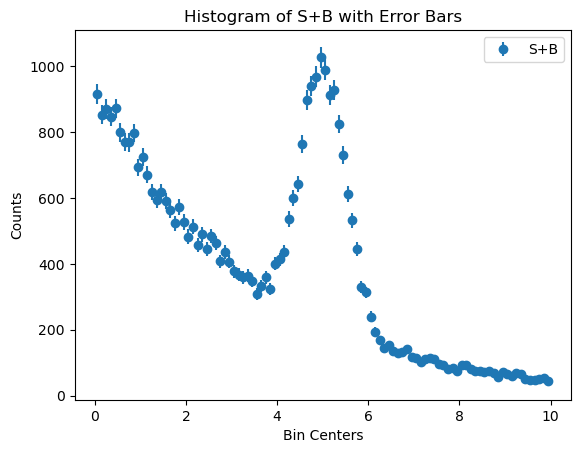

In [79]:
#plotting the histogram with error bars
import matplotlib.pyplot as plt
plt.errorbar(SplusB_bin_centers, SplusB_counts, yerr=SplusB_errors, fmt='o', label='S+B')
plt.xlabel('Bin Centers')
plt.ylabel('Counts')
plt.title('Histogram of S+B with Error Bars')
plt.legend()
plt.show()

In [80]:
# discovery p-value 
test_statistic_obs = log_likelihood(Mu_fit, a_fit_d, lam_fit_d, A_fit, mu_fit, sigma_fit, SplusB_counts, SplusB_bin_centers) - log_likelihood(0, a_fit, lam_fit, 0.0, 0.0, 1.0, SplusB_counts, SplusB_bin_centers)
p_value = 1 - chi2.cdf(test_statistic_obs, df=1)
print(f"Observed Test Statistic: {test_statistic_obs}")
print(f"Discovery p-value: {p_value}")

Observed Test Statistic: 58.99545421943185
Discovery p-value: 1.5765166949677223e-14


Therefore this is a discovery

# Question 2

In [104]:
Mass_hypotheses = [200, 400, 600, 800, 1000, 1200, 1500]
n_hypotheses = len(Mass_hypotheses)
M_gamma_cut = [180, 350, 500, 500, 500, 500, 500]
Signal_efficiencies = [0.387, 0.446, 0.47, 0.493, 0.509, 0.513, 0.529]
expected_signals = [40, 16, 6.4, 2.5, 1.0, 0.4, 0.1]
luminosity = 36 # in pb^-1

We assume that Standard Model predicts that the counts for the processes be distributed as a Gaussian with means:

In [116]:
N_pred_mean = [1.0, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01]

and standard deviations:

In [117]:
N_pred_std = [0.15, 0.07, 0.06, 0.06, 0.06, 0.06, 0.06]

Then, we can compute the upper limit on the number of signal counts at 95% confidence interval as follows:

In [118]:
def erf(x, mean, std):
    """Error function."""
    return (2 / np.sqrt(np.pi)) * np.exp(-((x - mean) ** 2) / (2 * std ** 2))

In [119]:
N_upper_limits = []
for i in range(n_hypotheses):
    mass = Mass_hypotheses[i]
    M_cut = M_gamma_cut[i]
    efficiency = Signal_efficiencies[i] / 100  # convert to fraction
    expected_signal = expected_signals[i]
    N_std = N_pred_std[i]
    N_mean = N_pred_mean[i]
    
    #calculating upper limit on number of signal counts at 95% confidence level
    area = 0.0
    N_upper = 2 * (N_std + N_mean)
    while area < 0.95:
        N_upper -= 0.01
        area = 0.5 * (1 + erf((N_upper - N_mean) / (N_std * np.sqrt(2)), N_mean, N_std))
    print(f"m* = {mass} GeV, upper limit on signal counts: {N_upper:.4f}")
    N_upper_limits.append(N_upper)
N_upper_limits = np.array(N_upper_limits)

m* = 200 GeV, upper limit on signal counts: 1.2300
m* = 400 GeV, upper limit on signal counts: 0.1100
m* = 600 GeV, upper limit on signal counts: 0.0100
m* = 800 GeV, upper limit on signal counts: 0.0100
m* = 1000 GeV, upper limit on signal counts: 0.0100
m* = 1200 GeV, upper limit on signal counts: 0.0100
m* = 1500 GeV, upper limit on signal counts: 0.0100


We know that $N = L * \sigma * \epsilon$

In [109]:
sigma_limits = N_upper_limits / (efficiency * luminosity)
print("Upper limits on cross-section (pb):")
for i in range(n_hypotheses):
    print(f"m* = {Mass_hypotheses[i]} GeV: {sigma_limits[i]:.4f} pb")

Upper limits on cross-section (pb):
m* = 200 GeV: 6.4587 pb
m* = 400 GeV: 0.5776 pb
m* = 600 GeV: 0.0525 pb
m* = 800 GeV: 0.0525 pb
m* = 1000 GeV: 0.0525 pb
m* = 1200 GeV: 0.0525 pb
m* = 1500 GeV: 0.0525 pb
